In [1]:
%pylab inline
import xcml
import siestah2o as h2o
import pickle
from mbpol_calculator import MbpolCalculator, reconnect_monomers
from ase import Atoms
import siesta_utils.grid as siesta
from ase.io import iread, read
import sys
sys.path.append('..')
import config as c
import pandas as pd

Populating the interactive namespace from numpy and matplotlib


/gpfs/home/smdick/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
basis = 'dz_custom'
features = 'descr'
path = '/gpfs/scratch/smdick/md_siesta_descr/'
every = 500

In [4]:
#Load relevant models 

e_model = False
f_model = False
fd_model = False
try:
    krr_O = pickle.load(open(c.model_basepath + c.par[features]['krr_o'][basis], 'rb'))
    krr_H = pickle.load(open(c.model_basepath + c.par[features]['krr_h'][basis], 'rb'))
#     krr_O = pickle.load(open('/gpfs/home/smdick/exchange_ml/models/final/krr_Oxygen_descr_seawulf', 'rb'))
#     krr_H = pickle.load(open('/gpfs/home/smdick/exchange_ml/models/final/krr_Hydrogen_descr_seawulf', 'rb'))
    f_model = True
except KeyError:
    print('No force model found')    
try:
    krr_O_dx = pickle.load(open(c.model_basepath + c.par[features]['krr_o_dx'][basis], 'rb'))
    krr_H_dx = pickle.load(open(c.model_basepath + c.par[features]['krr_h_dx'][basis], 'rb'))
    fd_model = True
except KeyError:
    print('No finite diff. model found')
try:
    nn = xcml.load_network(c.model_basepath + c.par[features]['nn'][basis])
    e_model = True
except KeyError:
    print('No energy model found')
    


INFO:tensorflow:Restoring parameters from /gpfs/home/smdick/exchange_ml/models/final/nn_descriptors_dz_symright/model.ckpt


In [5]:
def shrink_file(path, block_size, every):
    with open(path, 'r') as infile:
        with open(path[:-4] + '_small.dat', 'w') as outfile:
            for b in range(block_size):
                line = infile.readline()
            while(line):
                for b in range(block_size):
                    line = infile.readline()
                    outfile.write(line)
                for b in range((every-1)*block_size):
                    line = infile.readline()

In [6]:
# Load data 

if features == 'descr':
    n_o_orb = 18
    n_h_orb = 8
else:
    n_o_orb = c.par[features]['n_o_orb'][basis]
    n_h_orb = c.par[features]['n_h_orb'][basis]


shrink_file(path + '/siesta/features.dat', 128 * (n_o_orb + 2 * n_h_orb), every)
shrink_file(path + '/siesta/forces_siesta.dat', 128 * 3, every)
shrink_file(path + '/siesta/forces_corrected.dat', 128 * 3, every)

feat =  np.genfromtxt(path +'/siesta/features_small.dat').reshape(-1,128,n_o_orb + 2 * n_h_orb)
forces_siesta = np.genfromtxt(path +'/siesta/forces_siesta_small.dat').reshape(-1,128,3,3)
forces_corrected = np.genfromtxt(path + '/siesta/forces_corrected_small.dat').reshape(-1,128,3,3)
energies = pd.read_csv(path + '/siesta/energies.dat', delim_whitespace= True).iloc[1::every]
len(energies)

9

In [7]:
# Calculate reference data 
forces_mbpol = []
energies_mbpol = []
coords = []
all_atoms = []
max_len = len(pd.read_csv(path + '/siesta/energies.dat', delim_whitespace= True))
for index in np.arange(0, max_len,every):
    all_atoms.append(read(path + 'md_siesta.traj', index))

coor0 = np.array(all_atoms[0].get_positions())
atoms = all_atoms[0]
atoms = reconnect_monomers(atoms)
atoms = reconnect_monomers(atoms)
atoms.set_calculator(MbpolCalculator(atoms))

for a in all_atoms:
    
    atoms.set_positions(a.get_positions())
    atoms = reconnect_monomers(atoms)
    atoms = reconnect_monomers(atoms)
    coords.append(atoms.get_positions())
    energies_mbpol.append(atoms.get_potential_energy())
    forces_mbpol.append(atoms.get_forces())

In [8]:
energies_mbpol = np.array(energies_mbpol)
forces_mbpol = np.array(forces_mbpol).reshape(-1,128,3,3)
energies['Mbpol'] = energies_mbpol


In [9]:
rmse_force_siesta = []
rmse_force_corrected = []
max_force_siesta = []
max_force_corrected = []
for i in range(len(energies)):
    
    rmse_force_siesta.append(np.sqrt(np.mean((forces_siesta[i].flatten() - forces_mbpol[i].flatten())**2)))
    rmse_force_corrected.append(np.sqrt(np.mean((forces_corrected[i].flatten() - forces_mbpol[i].flatten())**2)))
    max_force_siesta.append(np.sqrt(np.max((forces_siesta[i].flatten() - forces_mbpol[i].flatten())**2)))
    max_force_corrected.append(np.sqrt(np.max((forces_corrected[i].flatten() - forces_mbpol[i].flatten())**2)))

NameError: name 'start' is not defined

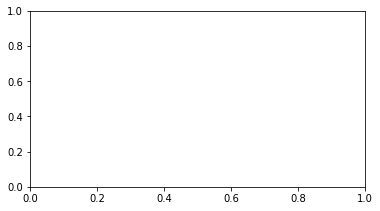

In [10]:
figsize(6,11)
subplot(3,1,1)
meandev_siesta = np.mean(energies['Mbpol'] - energies['Siesta'])
meandev_corrected = np.mean(energies['Mbpol'] - energies['Corrected'])
t = np.arange(start,100000,every)[:len(energies)]/2000
plot(t, energies['Siesta'] + meandev_siesta, ls = '--', marker = '.', label = 'Siesta')
plot(t, energies['Corrected'] + meandev_corrected, ls = '-.', marker = '.', label = 'Corrected')
plot(t, energies['Mbpol'], ls = '-', marker = '.', label = 'MB-pol')
xlabel('Time[ps]')
ylabel('Epot[eV]')
legend()
subplot(3,1,2)
meandev_siesta = np.mean(energies['Mbpol'] - energies['Siesta'])
meandev_corrected = np.mean(energies['Mbpol'] - energies['Corrected'])
# plot(energies['Mbpol'], ls = '-', marker = '.', label = 'MB-pol')
hist(abs(energies['Siesta'] + meandev_siesta-energies['Mbpol'])/0.128 ,
     label = 'Siesta,\n RMSE = {:.2f} meV/Molecule'.format(np.std(energies['Mbpol'] - energies['Siesta'])/0.128), alpha = 0.8,
     normed=True)
hist(abs(energies['Corrected'] + meandev_corrected - energies['Mbpol'])/0.128,
     label = 'Corrected,\n RMSE = {:.2f} meV/Molecule'.format(np.std(energies['Mbpol'] - energies['Corrected'])/0.128), alpha = 0.8,
     normed = True)
xlabel('Prediction error [meV/Molecule]')
ylabel('N')

legend()
subplot(3,1,3)
plot(t, rmse_force_siesta, ls = '-', marker = '', label = 'Siesta, RMSE')
plot(t, rmse_force_corrected, ls = '-', marker = '', label = 'Corrected, RMSE')
plot(t, max_force_siesta, ls = '--', marker = '', label = 'Siesta, Max. abs. error', color = 'C0')
plot(t, max_force_corrected, ls = '--', marker = '', label = 'Corrected, Max. abs. error', color = 'C1')
legend()
# savefig('../figs/{}_errors.pdf'.format(path[path.rfind('/',0,-2)+1:-1]))
# savefig('../figs/{}_errors.eps'.format(path[path.rfind('/',0,-2)+1:-1]))

In [11]:
if features == 'descr':
    symmetry = np.genfromtxt('../symmetry.dat')
else:
    symmetry = 0

0.5416603817813561
0.07849782057802386
0.07849821378022559


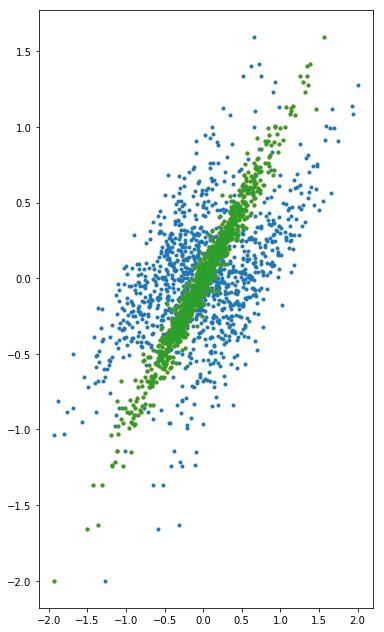

In [15]:
i = -1
corrections = xcml.use_force_model(feat[i], krr_O, krr_H, n_o_orb, n_h_orb, True, coords[i], sym = symmetry, 
                                   which_sym =[1, 2])
# corrections = xcml.use_force_model_fd(feat[i], krr_O_dx, krr_H_dx,nn, n_o_orb, n_h_orb, True, coords[i], sym = symmetry)
plot(forces_siesta[i].flatten(), forces_mbpol[i].flatten(), ls = '', marker = '.')
plot(forces_corrected[i].flatten(), forces_mbpol[i].flatten(),ls = '', marker = '.')
plot(forces_siesta[i].flatten() - corrections.flatten(), forces_mbpol[i].flatten(),ls = '', marker = '.')
print(np.std(forces_siesta[i].flatten() - forces_mbpol[i].flatten()))
print(np.std(forces_corrected[i].flatten() - forces_mbpol[i].flatten()))
print(np.std(forces_siesta[i].flatten() - corrections.flatten() - forces_mbpol[i].flatten()))

0.6316994491373515
0.16402342936818506
0.16402248013551268


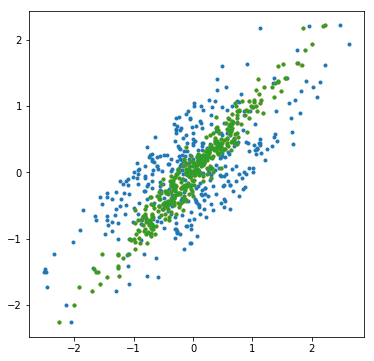

In [133]:
atom = 2
plot(forces_siesta[i,:,atom].flatten(), forces_mbpol[i,:, atom].flatten(), ls = '', marker = '.')
plot(forces_corrected[i,:, atom].flatten(), forces_mbpol[i,:, atom].flatten(),ls = '', marker = '.')
plot(forces_siesta[i,:, atom].flatten() - corrections[:,atom].flatten(), forces_mbpol[i,:, atom].flatten(),ls = '', marker = '.')
print(np.std(forces_siesta[i,:,atom].flatten() - forces_mbpol[i,:,atom].flatten()))
print(np.std(forces_corrected[i,:,atom].flatten() - forces_mbpol[i,:,atom].flatten()))
print(np.std(forces_siesta[i,:,atom].flatten() - corrections[:,atom].flatten() - forces_mbpol[i, :, atom].flatten()))

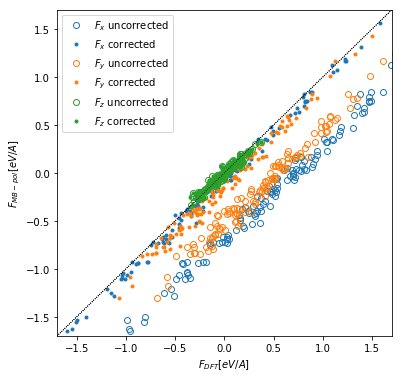

In [136]:
i = -1
a = 2
corrections = xcml.use_force_model(feat[i], krr_O, krr_H, n_o_orb, n_h_orb, False, coords[i], sym = symmetry, 
                                   which_sym =[])

coords_tiled = np.tile(coords[i].reshape(-1,1,3,3),[1,3,1,1]).reshape(-1,3,3)
force_siesta_local = np.array(forces_siesta[i])
force_mbpol_local = np.array(forces_mbpol[i])
force_siesta_local = xcml.in_local_cs(force_siesta_local.reshape(-1,3), coords_tiled).reshape(-1,3,3)
force_mbpol_local = xcml.in_local_cs(force_mbpol_local.reshape(-1,3), coords_tiled).reshape(-1,3,3)
labels = ['$F_{x}$','$F_y$', '$F_z$']
# corrections = xcml.use_force_model_fd(feat[i], krr_O_dx, krr_H_dx,nn, n_o_orb, n_h_orb, True, coords[i], sym = symmetry)
factor = [1,-1,1]
for i,f in zip(range(3),factor):
    plot(force_siesta_local[:,a,i].flatten()*f, force_mbpol_local[:,a,i].flatten()*f, ls = '', marker = 'o',
         color = 'C{}'.format(i), alpha = 1.0,  label = '{} uncorrected'.format(labels[i]), fillstyle = 'none')
    # plot(forces_corrected[i].flatten(), forces_mbpol[i].flatten(),ls = '', marker = '.')
    plot(force_siesta_local[:,a,i].flatten()*f - corrections[:,a,i].flatten()*f, force_mbpol_local[:,a,i].flatten()*f,ls = '', marker = '.',
        color = 'C{}'.format(i), label = '{} corrected'.format(labels[i]))
    plot([-1.7,1.7],[-1.7,1.7], color = 'black', ls =':', lw =.8, )
    xlim(-1.7,1.7)
    ylim(-1.7,1.7)
    xlabel('$F_{DFT}[eV/A]$')
    ylabel('$F_{MB-pol}[eV/A]$')
legend()

atoms = ['O','H1','H2']

savefig('../figs/forces_localcs_mull_{}.pdf'.format(atoms[a]))
savefig('../figs/forces_localcs_mull_{}.eps'.format(atoms[a]))

In [24]:
np.tile(coords[i].reshape(-1,1,3,3),[1,3,1,1]).reshape(-1,3,3)

array([[[ 5.83270299, 12.23094062,  4.00303012],
        [ 4.92129424, 12.41146307,  3.83522084],
        [ 5.93033006, 12.56165183,  4.88503524]],

       [[ 5.83270299, 12.23094062,  4.00303012],
        [ 4.92129424, 12.41146307,  3.83522084],
        [ 5.93033006, 12.56165183,  4.88503524]],

       [[ 5.83270299, 12.23094062,  4.00303012],
        [ 4.92129424, 12.41146307,  3.83522084],
        [ 5.93033006, 12.56165183,  4.88503524]],

       ...,

       [[11.00557443, 10.81950254,  3.80154762],
        [11.14022011,  9.98256862,  3.35823826],
        [11.7993385 , 11.33449596,  3.59772808]],

       [[11.00557443, 10.81950254,  3.80154762],
        [11.14022011,  9.98256862,  3.35823826],
        [11.7993385 , 11.33449596,  3.59772808]],

       [[11.00557443, 10.81950254,  3.80154762],
        [11.14022011,  9.98256862,  3.35823826],
        [11.7993385 , 11.33449596,  3.59772808]]])

In [16]:
force_siesta_local.shape

(128, 3, 3)

In [ ]:
force_siesta_local = xcml.in_local_cs

In [ ]:
if isinstance(sym,int):
    sym = np.array([1]*tmp.shape[1])
for i, s in enumerate(sym):
    if s == -2:
        sym[i] = 1
sym = sym.reshape(1,n_)
sym = np.tile(sym, [len(tmp),1])

In [53]:
dimers = np.genfromtxt('/gpfs/home/smdick/exchange_ml/data/synced/processed_dz/dimers/final/descriptors_coeff.dat', delimiter = ',').reshape(-1,34)[::10]

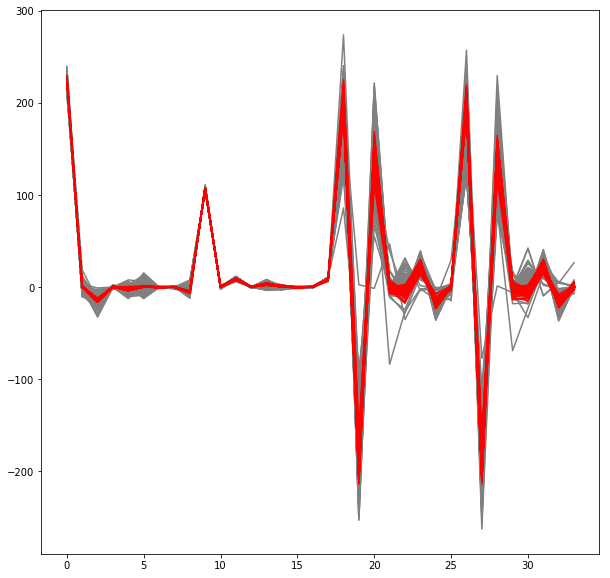

In [54]:
figsize(10,10)
plot(dimers.T, color = 'grey')
plot(feat[-1].T, color = 'red');